<a href="https://colab.research.google.com/github/SaqlainHussainShah/real-time-anomaly-detection/blob/master/Length_used_for_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import tensorflow as tf


In [0]:
from tensorflow import keras

In [0]:
df = pd.read_csv('/content/drive/My Drive/web_tcp_ip.csv')

In [0]:
df=df[df.columns[1:]]

In [174]:
len(df)

95433

In [0]:
df['time_taken']=df['start_time']-df['end_time']

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True) ##https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [0]:
df2=df[df.columns[:13]]

In [178]:
df2['time']=df['start_time']-df['end_time']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df = df2 

In [0]:
del df2

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = np.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(64).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [183]:
df.columns

Index(['sender_ip', 'destination_ip', 'protocol_ip', 'length', 'source_port',
       'destination_port', 'data_of_s', 'seq', 'ack', 'flags', 'window',
       'chksum', 'urgptr', 'time'],
      dtype='object')

In [0]:
input_values=df['length']

In [0]:
input_values = input_values[:30000]

In [0]:
time_step = np.arange(30000)


In [0]:
series = np.array(input_values)
time = np.array(time_step)

In [0]:
series = series/(np.max(series)-np.min(series))

In [0]:
split_time = 25000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 512
batch_size = 64
shuffle_buffer_size = 784

In [0]:
# x_train = x_train/(np.max(x_train)-np.min(x_train))
# x_valid = x_valid/(np.max(x_train)-np.min(x_train))

In [23]:

np.random.seed(51)
window_size = 256
batch_size = 64
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=64, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(25000,)
Epoch 1/64
387/387 [==============================] - 37s 95ms/step - loss: 0.2926 - mae: 0.6052 - lr: 1.0000e-08
Epoch 2/64
387/387 [==============================] - 37s 95ms/step - loss: 0.2589 - mae: 0.5634 - lr: 1.1220e-08
Epoch 3/64
387/387 [==============================] - 37s 95ms/step - loss: 0.2426 - mae: 0.5407 - lr: 1.2589e-08
Epoch 4/64
387/387 [==============================] - 37s 95ms/step - loss: 0.2274 - mae: 0.5157 - lr: 1.4125e-08
Epoch 5/64
387/387 [==============================] - 37s 95ms/step - loss: 0.2081 - mae: 0.4793 - lr: 1.5849e-08
Epoch 6/64
387/387 [==============================] - 37s 95ms/step - loss: 0.1860 - mae: 0.4363 - lr: 1.7783e-08
Epoch 7/64
387/387 [==============================] - 36s 94ms/step - loss: 0.1653 - mae: 0.4018 - lr: 1.9953e-08
Epoch 8/64
387/387 [==============================] - 36s 94ms/step - loss: 0.1460 - mae: 0.3753 - 

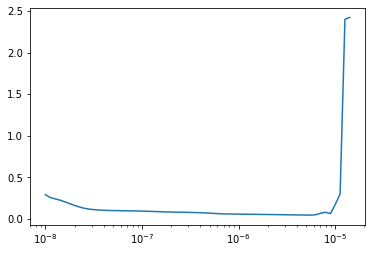

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])


In [139]:

np.random.seed(51)
window_size = 256
batch_size = 64
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=8.9125e-06, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=30)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(25000,)
Epoch 1/30
387/387 [==============================] - 36s 93ms/step - loss: 0.0876 - mae: 0.2650
Epoch 2/30
387/387 [==============================] - 36s 93ms/step - loss: 0.0416 - mae: 0.1959
Epoch 3/30
387/387 [==============================] - 36s 93ms/step - loss: 0.0407 - mae: 0.1942
Epoch 4/30
387/387 [==============================] - 36s 93ms/step - loss: 0.0403 - mae: 0.1931
Epoch 5/30
387/387 [==============================] - 36s 93ms/step - loss: 0.0400 - mae: 0.1927
Epoch 6/30
387/387 [==============================] - 36s 93ms/step - loss: 0.0399 - mae: 0.1924
Epoch 7/30
387/387 [==============================] - 36s 93ms/step - loss: 0.0397 - mae: 0.1922
Epoch 8/30
387/387 [==============================] - 36s 93ms/step - loss: 0.0397 - mae: 0.1921
Epoch 9/30
387/387 [==============================] - 36s 92ms/step - loss: 0.0396 - mae: 0.1919
Epoch 10/30
387/387 [===

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

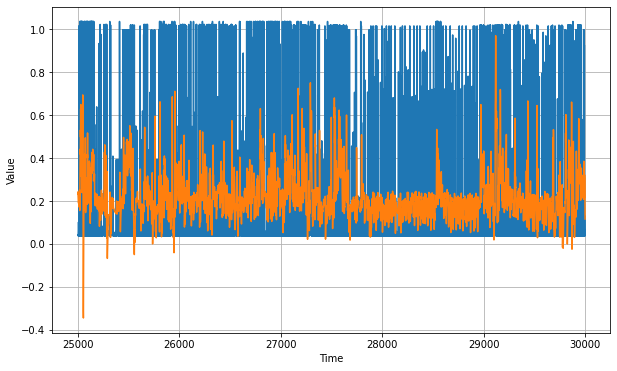

In [191]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [192]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.23853667

In [0]:
x_valid = x_valid * 1500

In [0]:
rnn_forecast = rnn_forecast * 1500

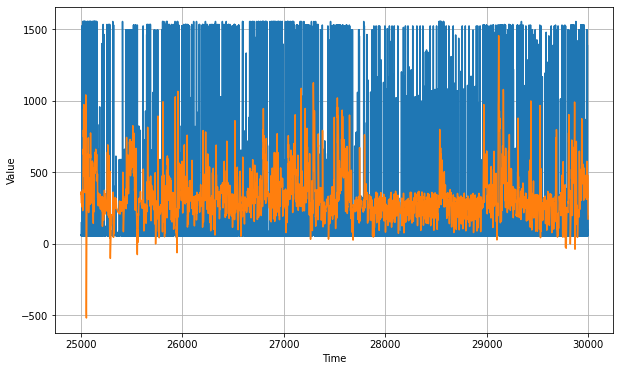

In [195]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [196]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

357.80505

In [0]:
try:
  model.save_weights("/content/drive/My Drive/model.h5")
except:
  print("Model not saved")

In [0]:
test_data = pd.read_csv('/content/drive/My Drive/testing.csv')

In [0]:
df2 = test_data[test_data.columns[1:]]

In [0]:
input_values=df2['length']

In [0]:
input_values = input_values[:30000]

In [0]:
time_step = np.arange(30000)


In [0]:
series = np.array(input_values)
time = np.array(time_step)

In [0]:
series = series/(np.max(series)-np.min(series))

In [0]:
split_time = 25000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 512
batch_size = 64
shuffle_buffer_size = 784

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

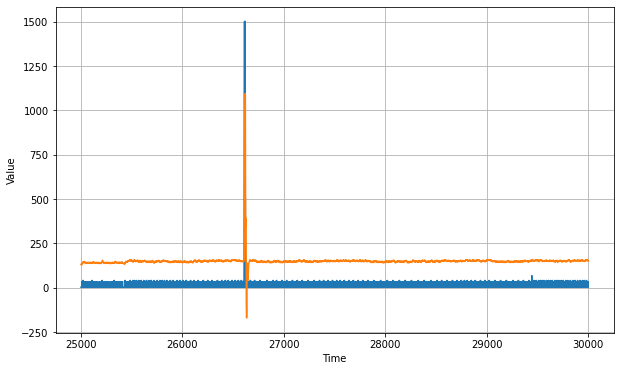

In [163]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [164]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

137.39522